In [118]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.cm as cm

In [119]:
# processing the datset before using it

data_set = pd.read_csv("epoch_clustering_data.csv")
last_three_columns = data_set.iloc[: , -3:]
gujarat_data = last_three_columns[last_three_columns['StateName'] == "GUJARAT"].copy()
features = gujarat_data[['Latitude', 'Longitude']]
X = features.to_numpy()

/tmp/ipykernel_9419/3099512527.py:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data_set = pd.read_csv("epoch_clustering_data.csv")


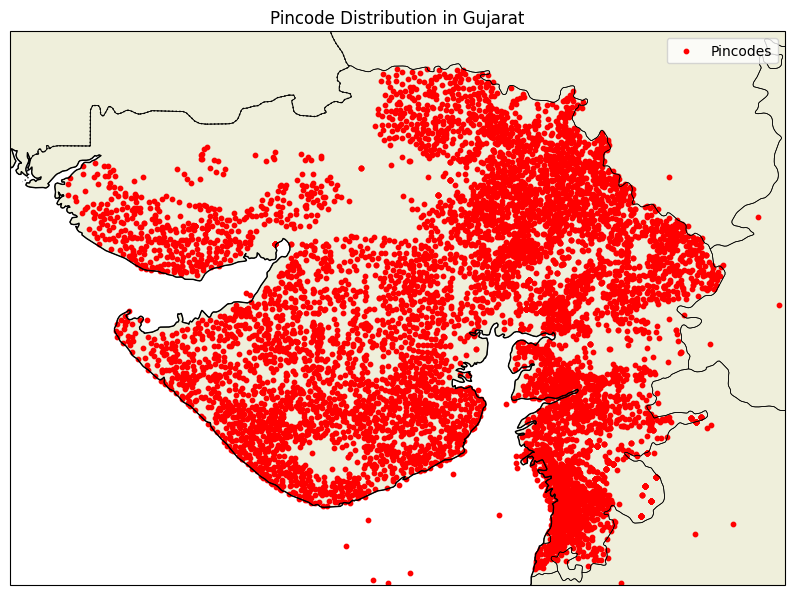

In [120]:
'''
This part of the code maps all the points on the map of gujarat
it helps visualize the spread of the data-points
'''

# Load your DataFrame (gujarat_data)
df = gujarat_data

# Convert to float (forcefully)
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

# Drop any rows that couldn't be converted (became NaN)
df = df.dropna(subset=['Latitude', 'Longitude'])

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linewidth=0.5)

ax.set_extent([68, 75, 20, 25], crs=ccrs.PlateCarree())

ax.scatter(df['Longitude'], df['Latitude'], color='red', s=10, label='Pincodes', transform=ccrs.PlateCarree())

plt.title("Pincode Distribution in Gujarat")
plt.legend()
plt.show()


In [121]:
# Defining class "K_means" for all the methods and properties required for implementing it

class K_means:
    # initializing the class
    def __init__ (self, n_clusters, max_iters=100, tolerance=1e-4):
        self.n_clusters = n_clusters
        self.max_iterations = max_iters
        self.tolerance = tolerance
        self.centroids = None
        self.old_centroids = None

    # this function randomly initializes all the centroid from the give set of point
    def initialize_centroids(self , X):
        indices = np.random.choice(len(X), self.n_clusters , replace=False ) # this randomly selects K random indexes from all the points
        self.centroids = X[indices].copy()
        self.old_centroids = X[indices].copy() # this is the list of randomly selected K points to be the centroid

    # Assigns labels to all the points on the basis of which centroid is closest to them
    def assign_cluster (self , X):
        labels = []
        for point in X: # selected point from all the points
            least_distance = math.inf
            cluster_index = None

            for i in range(len(self.centroids)): # Now selecting every centroid sequentially
                centroid = self.centroids[i]
                # now we will compute distances of point from all the centroid
                distance = math.sqrt((point[0]-centroid[0])**2+(point[1]-centroid[1])**2)

                if distance<least_distance:
                    least_distance = distance
                    cluster_index = i

            # now we have index of closest centroid to the given point
            labels.append(cluster_index)

        return labels

    # it updates centroid based on the average latitue and longitute values of the given cluster
    def update_centroid (self , X , labels):
        new_centroids = []
        for cluster_index in range(self.n_clusters):
            list_of_cluster_points = X[labels == cluster_index].copy()
            mean_latitude = np.mean([point[0] for point in list_of_cluster_points])
            mean_longitude = np.mean([point[1] for point in list_of_cluster_points])
            new_centroids.append([mean_latitude , mean_longitude])

        self.old_centroids = self.centroids
        self.centroids = np.array(new_centroids)


    def check_tolerance(self):
        total_movement = np.linalg.norm(self.old_centroids - self.centroids)
        return total_movement < self.tolerance
    
    # this is the main function which group all the methods and is used to train the model on given features
    def fit(self , X):
        self.initialize_centroids(X)

        for iteration in range(self.max_iterations):
            # Assign each point to the nearest centroid, labels is a list where nth index value is label of nth point's cluster
            labels = self.assign_cluster(X)

            # Store the current centroids before updating. Will be used for tolerance calculation
            self.old_centroids = self.centroids.copy()

            # Update the centroid positions based on current cluster assignments
            self.update_centroid(X, np.array(labels))

            # Check if centroids have stopped moving significantly (convergence)
            if self.check_tolerance():
                print(f"Converged in {iteration+1} iterations.")
                break

        return labels

# WCSS score calculation function
def WCSS_calculation(X , max_k = 15):
    wcss_scores = []
    for k in range(2, max_k+1):
        kmeans = K_means(n_clusters=k)
        labels = kmeans.fit(X)
        
        # Calculate sum of squared distances to closest centroid (WCSS score)
        square_sum = 0
        for index ,point_label in enumerate(labels):
            centroid = kmeans.centroids[point_label]
            point = X[index]
            square_sum += np.sum((point[0] - centroid[0]) ** 2+(point[1] - centroid[1]) ** 2)
        wcss_scores.append(square_sum)
    return wcss_scores


# detemination of optimal "k" value based on WCSS score
def determine_optimal_k(wcss):
    """Automatically find elbow point using knee locator method"""
    from kneed import KneeLocator  # Note: This might need installation
    kl = KneeLocator(range(1, len(wcss)+1), wcss, curve='convex', direction='decreasing')
    return kl.elbow+1


Converged in 6 iterations.
Converged in 6 iterations.
Converged in 12 iterations.
Converged in 20 iterations.
Converged in 22 iterations.
Converged in 15 iterations.
Converged in 38 iterations.
Converged in 35 iterations.
Converged in 63 iterations.
Converged in 64 iterations.
Converged in 32 iterations.
Converged in 38 iterations.
Converged in 25 iterations.
Converged in 74 iterations.


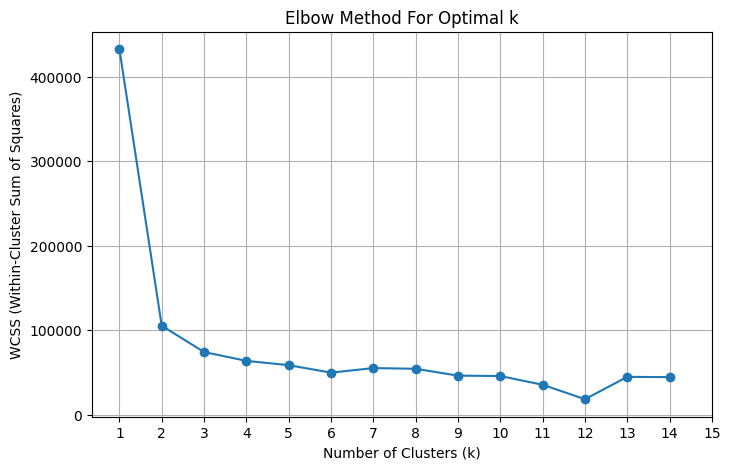

Converged in 34 iterations.


/tmp/ipykernel_9419/816314529.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', kmeans.n_clusters)


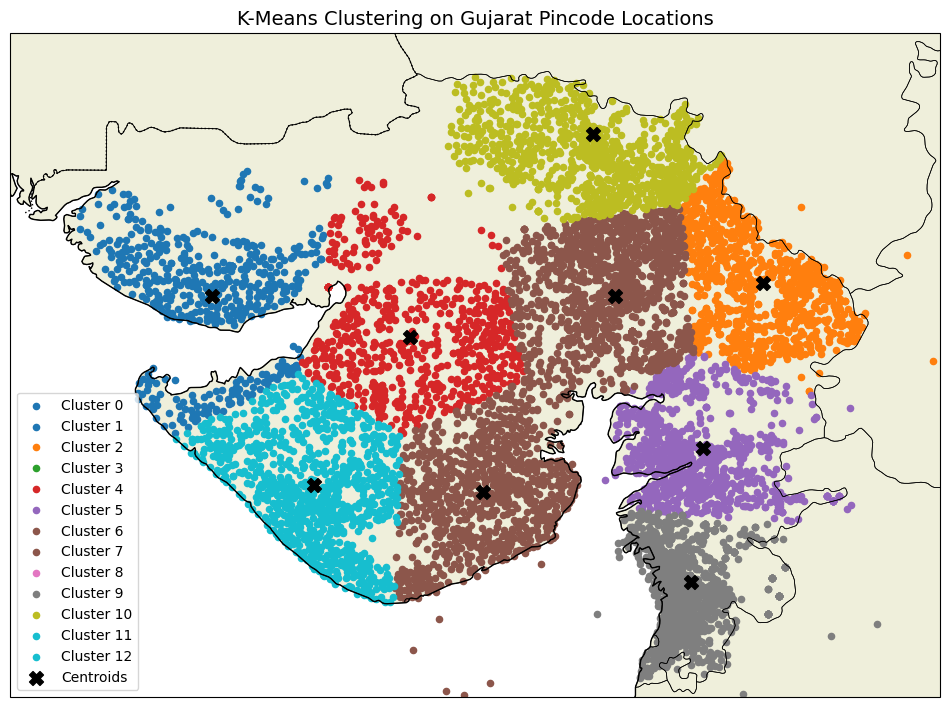


 Final Cluster Centroids:
Cluster 0: Latitude = 23.01726, Longitude = 69.52159
Cluster 1: Latitude = 15.59668, Longitude = 73.28966
Cluster 2: Latitude = 23.11938, Longitude = 73.66411
Cluster 3: Latitude = 17.33164, Longitude = 85.03250
Cluster 4: Latitude = 22.70976, Longitude = 71.00772
Cluster 5: Latitude = 21.87449, Longitude = 73.21700
Cluster 6: Latitude = 23.01521, Longitude = 72.55181
Cluster 7: Latitude = 21.54071, Longitude = 71.56354
Cluster 8: Latitude = 66.24899, Longitude = 21.21534
Cluster 9: Latitude = 20.86756, Longitude = 73.12349
Cluster 10: Latitude = 24.23946, Longitude = 72.38458
Cluster 11: Latitude = 23.14000, Longitude = 7192.00000
Cluster 12: Latitude = 21.59247, Longitude = 70.28911

 Cluster Distribution:
Cluster 0: 535 points
Cluster 1: 608 points
Cluster 2: 981 points
Cluster 3: 70 points
Cluster 4: 685 points
Cluster 5: 867 points
Cluster 6: 1397 points
Cluster 7: 849 points
Cluster 8: 72 points
Cluster 9: 1159 points
Cluster 10: 796 points
Cluster 11: 

In [123]:
# Data-cleaning step for converting all the value from string type to numerics and dropping the missing data
gujarat_data['Latitude'] = pd.to_numeric(gujarat_data['Latitude'], errors='coerce')
gujarat_data['Longitude'] = pd.to_numeric(gujarat_data['Longitude'], errors='coerce')
gujarat_data = gujarat_data.dropna(subset=['Latitude', 'Longitude'])

# Preparing data again after cleaning
features = gujarat_data[['Latitude', 'Longitude']]
X = features.to_numpy()
wcss = WCSS_calculation(X, max_k=15)
# optimal_value_of_k = determine_optimal_k(wcss)
optimal_value_of_k = 13

# Plotting the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 15), wcss, marker='o', linestyle='-')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(range(1, 16))
plt.grid(True)
plt.show()

# fitting K_means classifier for ideal "k" value
kmeans = K_means(n_clusters=optimal_value_of_k)
labels = np.array(kmeans.fit(X))

# Final centroids
centroids = kmeans.centroids

# Color-coded Cluster Map
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Focus on Gujarat
ax.set_extent([68, 75, 20, 25], crs=ccrs.PlateCarree())

# Color map
colors = cm.get_cmap('tab10', kmeans.n_clusters)

# Plot each cluster
for cluster_index in range(kmeans.n_clusters):
    cluster_points = X[labels == cluster_index]
    ax.scatter(
        cluster_points[:, 1],  # Longitude
        cluster_points[:, 0],  # Latitude
        color=colors(cluster_index),
        label=f"Cluster {cluster_index}",
        s=20,
        transform=ccrs.PlateCarree()
    )

# Plot centroids
ax.scatter(
    centroids[:, 1],  # Longitude
    centroids[:, 0],  # Latitude
    color='black', marker='X', s=100,
    label='Centroids', transform=ccrs.PlateCarree()
)

plt.title("K-Means Clustering on Gujarat Pincode Locations", fontsize=14)
plt.legend()
plt.show()

# Text Summary
print("\n Final Cluster Centroids:")
for idx, centroid in enumerate(centroids):
    print(f"Cluster {idx}: Latitude = {centroid[0]:.5f}, Longitude = {centroid[1]:.5f}")

print("\n Cluster Distribution:")
unique, counts = np.unique(labels, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"Cluster {cluster}: {count} points")
